In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir <your log folder>

In [2]:
import random
import pickle
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from torch import nn, optim, autograd
from sklearn.preprocessing import MinMaxScaler
from math import cos, pi
from datetime import datetime
from torch.nn.utils.parametrizations import spectral_norm

In [3]:
# Constants.
INPUT_LAYER_DIM = 36
INPUT_LAYER_OUT = 256
SECOND_LAYER_OUT = 512
THIRD_LAYER_OUT = 1024
FOURTH_LAYER_OUT = 512
FIFTH_LAYER_OUT = 256
OUTPUT_LAYER_OUT = 36
T_MIN, T_MAX = 0, 36
BATCH_SIZE = 128
R_MIN, R_MAX = 0, 1
NUM_OF_SAMPLES = 2_000_000

DATA_LOADER_CONFIG = {
    "batch_size": BATCH_SIZE,
    "shuffle": True,
    "num_workers": 4
}

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Device is {DEVICE}")

LOG_DIR = "/root/odev/logs/" + datetime.now().strftime("%d-%m-%Y-%H%M%S")
GENERATOR_MODEL_PATH = "/root/odev/generator/"
DISCRIMINATOR_MODEL_PATH = "/root/odev/discriminator/"
IMAGE_PATH = "/root/odev/images/"

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Init Mersenne-Twister.
mersenne_twister = random.Random(42)

Device is cuda:0


In [4]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(INPUT_LAYER_DIM, INPUT_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(INPUT_LAYER_OUT, SECOND_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(SECOND_LAYER_OUT, THIRD_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(THIRD_LAYER_OUT, FOURTH_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(FOURTH_LAYER_OUT, FIFTH_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(FIFTH_LAYER_OUT, OUTPUT_LAYER_OUT),
            nn.LeakyReLU()
        )

    def forward(self, x):
        output = self.net(x)
        return output.reshape(-1)

In [5]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            # TODO: Burada kalmıştık.
            spectral_norm(nn.Linear(INPUT_LAYER_DIM, INPUT_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(INPUT_LAYER_OUT, SECOND_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(SECOND_LAYER_OUT, THIRD_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(THIRD_LAYER_OUT, FOURTH_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(FOURTH_LAYER_OUT, FIFTH_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(FIFTH_LAYER_OUT, 1)),
            nn.Sigmoid(),
        )

    def forward(self, z):
        output = self.net(z)
        return output

In [6]:
def gradient_penalty(Disc, xr, xf):
    """
    :param D:
    :param xr: [b, 2]
    :param xf: [b, 2]
    :return:
    """
    # [b, 1]
    t = torch.rand(BATCH_SIZE, 1).cuda()
    # [b, 1] => [b, 2]  broadcasting so t is the same for x1 and x2
    t = t.expand_as(xr)
    # interpolation
    mid = (t * xr) + ((1 - t) * xf)
    # set it to require grad info
    mid.requires_grad_()
    pred = Disc(mid)
    grads = autograd.grad(
        outputs=pred,
        inputs=mid,
        grad_outputs=torch.ones_like(pred),
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]

    # Yeni ekledim.
    grads = grads.reshape([xr.shape[0], -1])

    gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()
    return gp

# Data

## Create dataset and save it to google drive (doktora_data)

In [12]:
# Scale between .0 and 1
def scale(num):
    scaled_num = num - .5
    return scaled_num

In [17]:
# Generate data.
def generate_data():
    data = []
    for el in range(NUM_OF_SAMPLES):
        r_1 = random.random()
        r_2 = random.random()
        temp = []
        for t in range(T_MIN, T_MAX):
            temp.append(scale((cos((2 * r_1 * pi * t) + (2 * r_2 * pi)) * .5) + 1))
        data.append(torch.tensor(temp, dtype=torch.float64))
    return data

random_number_data_set = generate_data()

with open("/root/odev/data/tensor_data_list.pkl", "wb") as f:
    pickle.dump(random_number_data_set, f)

## Read data from google drive.

In [12]:
# Non-random number dataset.
with open("/root/odev/data/tensor_data_list.pkl", "rb") as f:
    random_number_data_set = pickle.load(f)


In [13]:
# Random number dataset.
with open("/root/odev/data/mt_tensor_data_list.pkl", "rb") as f:
    mt_random_number_data_set = pickle.load(f)


## Create Mersenne Twister Dataset

In [18]:
# Generate data.
def generate_mt_data():
    data = []
    for el in range(NUM_OF_SAMPLES):
        temp = []
        for t in range(T_MIN, T_MAX):
            temp.append(mersenne_twister.random())
        data.append(torch.tensor(temp, dtype=torch.float64))
    return data

mt_random_number_data_set = generate_mt_data()

with open("/root/odev/data/mt_tensor_data_list.pkl", "wb") as f:
    pickle.dump(mt_random_number_data_set, f)

## Create dataset object.

In [14]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, number_data):
        self.data = number_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Select sample
        return self.data[index]


In [15]:
training_set = Dataset(random_number_data_set)
mt_set = Dataset(mt_random_number_data_set)

training_generator = torch.utils.data.DataLoader(
    training_set,
    **DATA_LOADER_CONFIG
)

mt_generator = torch.utils.data.DataLoader(
    mt_set,
    **DATA_LOADER_CONFIG
)

## Data Visualization

In [16]:
def visualize_data(data):
    plt.figure(figsize=(36,1))
    data_reshaped = np.array(data).reshape(36, 1)
    plt.imshow(data_reshaped.T, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

In [17]:
def visualize_batch(data, title, epoch):
    data_stacked = np.column_stack(data)
    # plt.figure(figsize=(4,64))
    plt.imshow(data_stacked.T, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    
    path = IMAGE_PATH + f"{title}-" + f"{epoch}.png"
    plt.savefig(path)
    
    plt.show()

In [ ]:
# Visualize for the first batch.
visualize_batch(random_number_data_set[:1280], "", 1)

# Start training

In [ ]:
# TODO: 1. Apply spectral_normalization to discriminator. [Done]
# TODO: 2. NIST test for each 3000 epoch.
# TODO: 3. Save images to a directory.
# TODO: 4. RMSProp ile karşılaştırma.
# TODO: 5. MT yerine cryptographically secure random number generator deneyeceğim.

In [26]:
def save_model(epoch, gen_state_dict, gen_optim_state_dict, gen_loss, gen_path, disc_state_dict, disc_optim_state_dict, disc_loss, disc_path):
    # TODO: Refactor.
    try:
        # Save generator.
        genarator_path_base = gen_path + datetime.now().strftime("%d-%m-%Y-%H%M%S") + "/"
        generator_path = genarator_path_base + "generator.pth"
        
        if not os.path.exists(genarator_path_base):
            os.makedirs(genarator_path_base)
            print(f"Folder '{genarator_path_base}' created successfully.")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': gen_state_dict,
            'optimizer_state_dict': gen_optim_state_dict,
            'loss': gen_loss,
        }, generator_path)
    except Exception as e:
        print(e)
    # Save discriminator.
    try:
        discriminator_path_base = disc_path + datetime.now().strftime("%d-%m-%Y-%H%M%S") + "/"
        discriminator_path = discriminator_path_base + "discriminator.pth"
        
        if not os.path.exists(discriminator_path_base):
            os.makedirs(discriminator_path_base)
            print(f"Folder '{discriminator_path_base}' created successfully.")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': disc_state_dict,
            'optimizer_state_dict': disc_optim_state_dict,
            'loss': disc_loss,
        }, discriminator_path)
        
    except Exception as e:
        print(e)


Iteration: 0
(1.7532403469085693, -0.4784684181213379, 0)
Pseudo random number:


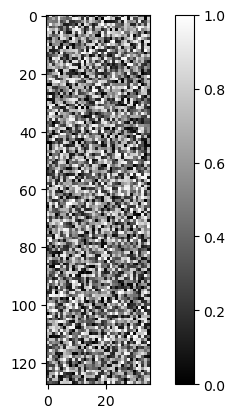

Generated random number:


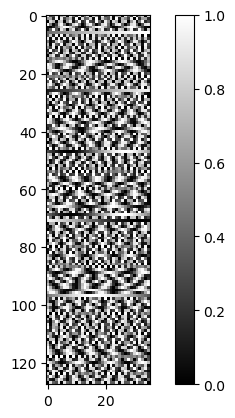

Folder '/root/odev/generator/25-12-2023-112549/' created successfully.
Folder '/root/odev/discriminator/25-12-2023-112549/' created successfully.


In [27]:
def main():

    # Load models.
    Gen = Generator().to(DEVICE)
    Disc = Discriminator().to(DEVICE)

    # print("Generator")
    # print(Gen)
    # print("Discriminator")
    # print(Disc)

    optim_G = optim.Adam(Gen.parameters(), lr=0.0001, betas=(0.0, 0.9), weight_decay=2e-5)
    optim_D = optim.Adam(Disc.parameters(), lr=0.0001, betas=(0.0, 0.9), weight_decay=2e-5)
    # Visualize: viz.line([[0, 0]], [0], win='loss', opts=dict(title='loss', legend=['D', 'G']))
    for iteration in range(1):
        # Discriminator training.
        for _ in range(5):  # train Discriminator 5 times.
            # 1.1 train on real data
            xr = next(enumerate(mt_generator))[1]
            xr = xr.to(torch.float32).to(DEVICE)
            # [b, 2] => [b, 1]
            predr = Disc(xr)
            lossr = -predr.mean()
            # 1.2 train on fake data
            # z=[b, 2]
            z = next(enumerate(training_generator))[1]
            z = z.to(torch.float32).to(DEVICE)
            xf = Gen(z).detach()  # gradient would be passed down
            xf = torch.reshape(xf, [BATCH_SIZE, 36])
            predf = Disc(xf)
            # min predf
            lossf = predf.mean()
            # 1.3 gradient penalty
            gp = gradient_penalty(Disc, xr, xf.detach())
            # aggregate all
            # loss_D = lossr + lossf + 0.2 * gp
            # Burayı yeni ekledim.
            x_out = torch.cat([predr, predf])
            loss_D = (lossr + lossf) + (gp * 2) + (x_out ** 10).mean() + .0001
            # optimize
            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()

        # 2. train G
        z = next(enumerate(training_generator))[1]
        z = z.to(torch.float32).to(DEVICE)
        xf = Gen(z)
        xf = torch.reshape(xf, [BATCH_SIZE, 36])
        predf = Disc(xf)
        # maximize predf.mean()
        loss_G = -predf.mean()
        # optimize
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()
        
        print(f"Iteration: {iteration}")

        if iteration % 100 == 0:
            print((loss_D.item(), loss_G.item(), iteration))
            # viz.line([[loss_D.item(), loss_G.item()]], [epoch], win='loss', update='append')
            # print(loss_D.item(), loss_G.item())
            print("Pseudo random number:")
            visualize_batch(xr.cpu().numpy(), "Real Random number", iteration)
            print("Generated random number:")
            visualize_batch(z.cpu().numpy(), "Generated Random number", iteration)

        if iteration % 1000 == 0 and iteration > 0:
            save_model(
                iteration,
                Gen.state_dict(),
                optim_G.state_dict(),
                loss_G,
                GENERATOR_MODEL_PATH,
                Disc.state_dict(),
                optim_D.state_dict(),
                loss_D,
                DISCRIMINATOR_MODEL_PATH
            )

    save_model(
        iteration,
        Gen.state_dict(),
        optim_G.state_dict(),
        loss_G,
        GENERATOR_MODEL_PATH,
        Disc.state_dict(),
        optim_D.state_dict(),
        loss_D,
        DISCRIMINATOR_MODEL_PATH
    )
    
    return (
        Gen.state_dict(),
        optim_G.state_dict(),
        loss_G,
        GENERATOR_MODEL_PATH,
        Disc.state_dict(),
        optim_D.state_dict(),
        loss_D,
        DISCRIMINATOR_MODEL_PATH
    )

res = main()

In [ ]:
# Sunumda gösterilebilecekler:
# 1. _2 ile biten image lar (Done)
# NIST karşılaştırması ve beklenen çalışma şekli. Hiç train edilmeden ve train edilmişken ki hali?
# CPU inference hızı.
# CPU inference da quantization aware yapalım ve hızını karşılaştıralım.
# Neden GAN kullandığımız destekelyecek referanslar verelim.
# Sonraki adımların neler olacağını anlatalım.

In [ ]:
# 200 mb lık bir alanda train edebiliyoruz.